## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, regular_type, output_units=10, num_neurons=[512, 256, 128, 64, 32], ratio=1e-12, drop_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regular_type(ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regular_type(ratio))(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drop_ratio)(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [64, 128, 256, 512]
Dropout_EXP = [0.1, 0.15, 0.2, 0.25, 0.3]
EXP = 1e-12

In [7]:
results = {}
for i, (drop_exp, batch_size) in enumerate(itertools.product(Dropout_EXP, BATCH_SIZE)):
    print("Numbers of exp: %i, drop_exp: %s, batch_size: %i, L1 ratio: %i" % (i, drop_exp, batch_size, EXP))
    model = build_mlp(input_shape=x_train.shape[1:], ratio=EXP, regular_type=l1, drop_ratio=drop_exp)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = "dp-%s, bs: %s" % (str(drop_exp),str(batch_size))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, drop_exp: 0.1, batch_size: 64, L1 ratio: 0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________

Epoch 35/50
782/782 [==============================] - 9s 12ms/step - loss: 0.6219 - accuracy: 0.7844 - val_loss: 1.6852 - val_accuracy: 0.5020
Epoch 36/50
782/782 [==============================] - 9s 12ms/step - loss: 0.6126 - accuracy: 0.7920 - val_loss: 1.7028 - val_accuracy: 0.5146
Epoch 37/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5981 - accuracy: 0.7939 - val_loss: 1.7379 - val_accuracy: 0.4946
Epoch 38/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5886 - accuracy: 0.8010 - val_loss: 1.7579 - val_accuracy: 0.5048
Epoch 39/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5755 - accuracy: 0.8008 - val_loss: 1.6842 - val_accuracy: 0.5238
Epoch 40/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5656 - accuracy: 0.8064 - val_loss: 1.8640 - val_accuracy: 0.4898
Epoch 41/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5571 - accuracy: 0.8100 - val_loss: 1.6593 - val_accuracy:

Epoch 19/50
391/391 [==============================] - 5s 13ms/step - loss: 0.8667 - accuracy: 0.6992 - val_loss: 1.6975 - val_accuracy: 0.4720
Epoch 20/50
391/391 [==============================] - 5s 13ms/step - loss: 0.8459 - accuracy: 0.7092 - val_loss: 1.8778 - val_accuracy: 0.4495
Epoch 21/50
391/391 [==============================] - 5s 13ms/step - loss: 0.8122 - accuracy: 0.7234 - val_loss: 1.8191 - val_accuracy: 0.4444
Epoch 22/50
391/391 [==============================] - 5s 13ms/step - loss: 0.7974 - accuracy: 0.7245 - val_loss: 1.5587 - val_accuracy: 0.4991
Epoch 23/50
391/391 [==============================] - 5s 13ms/step - loss: 0.7731 - accuracy: 0.7355 - val_loss: 1.7406 - val_accuracy: 0.4512
Epoch 24/50
391/391 [==============================] - 5s 13ms/step - loss: 0.7488 - accuracy: 0.7420 - val_loss: 1.5322 - val_accuracy: 0.5022
Epoch 25/50
391/391 [==============================] - 5s 13ms/step - loss: 0.7325 - accuracy: 0.7465 - val_loss: 1.6408 - val_accuracy:

Epoch 3/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4872 - accuracy: 0.4749 - val_loss: 1.8312 - val_accuracy: 0.3414
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4160 - accuracy: 0.4993 - val_loss: 1.9171 - val_accuracy: 0.3577
Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 1.3578 - accuracy: 0.5213 - val_loss: 1.7570 - val_accuracy: 0.3773
Epoch 6/50
196/196 [==============================] - 3s 15ms/step - loss: 1.3028 - accuracy: 0.5426 - val_loss: 1.6464 - val_accuracy: 0.4205
Epoch 7/50
196/196 [==============================] - 3s 15ms/step - loss: 1.2609 - accuracy: 0.5557 - val_loss: 1.5815 - val_accuracy: 0.4348
Epoch 8/50
196/196 [==============================] - 3s 15ms/step - loss: 1.2170 - accuracy: 0.5745 - val_loss: 1.6062 - val_accuracy: 0.4361
Epoch 9/50
196/196 [==============================] - 3s 15ms/step - loss: 1.1769 - accuracy: 0.5883 - val_loss: 1.5200 - val_accuracy: 0.4661

Epoch 1/50
98/98 [==============================] - 2s 25ms/step - loss: 1.9230 - accuracy: 0.3233 - val_loss: 1.8881 - val_accuracy: 0.3266
Epoch 2/50
98/98 [==============================] - 2s 20ms/step - loss: 1.6205 - accuracy: 0.4296 - val_loss: 1.9217 - val_accuracy: 0.2940
Epoch 3/50
98/98 [==============================] - 2s 20ms/step - loss: 1.5034 - accuracy: 0.4700 - val_loss: 1.7871 - val_accuracy: 0.3519
Epoch 4/50
98/98 [==============================] - 2s 23ms/step - loss: 1.4269 - accuracy: 0.4976 - val_loss: 1.9490 - val_accuracy: 0.3461
Epoch 5/50
98/98 [==============================] - 2s 20ms/step - loss: 1.3623 - accuracy: 0.5208 - val_loss: 1.6431 - val_accuracy: 0.4164
Epoch 6/50
98/98 [==============================] - 2s 20ms/step - loss: 1.3076 - accuracy: 0.5416 - val_loss: 1.8422 - val_accuracy: 0.3724
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 1.2643 - accuracy: 0.5580 - val_loss: 1.7018 - val_accuracy: 0.4075
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 11s 14ms/step - loss: 1.8824 - accuracy: 0.3324 - val_loss: 1.7925 - val_accuracy: 0.3757
Epoch 2/50
782/782 [==============================] - 10s 13ms/step - loss: 1.6404 - accuracy: 0.4188 - val_loss: 1.6823 - val_accuracy: 0.3866
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 1.5534 - accuracy: 0.4540 - val_loss: 1.7026 - val_accuracy: 0.3949
Epoch 4/50
782/782 [==============================] - 10s 13ms/step - loss: 1.4822 - accuracy: 0.4774 - val_loss: 1.4923 - val_accuracy: 0.4672
Epoch 5/50
782/782 [==============================] - 10s 13ms/step - loss: 1.4304 - accuracy: 0.4986 - val_loss: 1.7105 - val_accuracy: 0.4049
Epoch 6/50
782/782 [==============================] - 10s 13ms/step - loss: 1.3897 - accuracy: 0.5126 - val_loss: 1.5671 - val_accuracy: 0.4382
Epoch 7/50
782/782 [==============================] - 10s 13ms/step - loss: 1.3465 - accuracy: 0.5285 - val_loss: 1.5689 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 6s 16ms/step - loss: 1.8865 - accuracy: 0.3280 - val_loss: 1.7278 - val_accuracy: 0.3793
Epoch 2/50
391/391 [==============================] - 5s 14ms/step - loss: 1.6337 - accuracy: 0.4173 - val_loss: 1.9184 - val_accuracy: 0.3250
Epoch 3/50
391/391 [==============================] - 5s 14ms/step - loss: 1.5312 - accuracy: 0.4576 - val_loss: 2.0580 - val_accuracy: 0.3033
Epoch 4/50
391/391 [==============================] - 5s 14ms/step - loss: 1.4600 - accuracy: 0.4849 - val_loss: 1.5278 - val_accuracy: 0.4567
Epoch 5/50
391/391 [==============================] - 6s 14ms/step - loss: 1.4144 - accuracy: 0.5031 - val_loss: 1.8824 - val_accuracy: 0.3610
Epoch 6/50
391/391 [==============================] - 5s 14ms/step - loss: 1.3678 - accuracy: 0.5203 - val_loss: 1.7177 - val_accuracy: 0.3756
Epoch 7/50
391/391 [==============================] - 5s 14ms/step - loss: 1.3264 - accuracy: 0.5362 - val_loss: 1.7047 - val_accuracy: 0.3985

Epoch 1/50
196/196 [==============================] - 4s 19ms/step - loss: 1.9230 - accuracy: 0.3136 - val_loss: 1.7868 - val_accuracy: 0.3672
Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6586 - accuracy: 0.4074 - val_loss: 1.7387 - val_accuracy: 0.3796
Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5543 - accuracy: 0.4474 - val_loss: 1.9666 - val_accuracy: 0.3047
Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4862 - accuracy: 0.4755 - val_loss: 1.8031 - val_accuracy: 0.3600
Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4254 - accuracy: 0.4976 - val_loss: 1.7723 - val_accuracy: 0.3808
Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3728 - accuracy: 0.5167 - val_loss: 1.5633 - val_accuracy: 0.4371
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3338 - accuracy: 0.5322 - val_loss: 1.5985 - val_accuracy: 0.4319

Epoch 1/50
98/98 [==============================] - 4s 45ms/step - loss: 1.9735 - accuracy: 0.2977 - val_loss: 1.9033 - val_accuracy: 0.3217
Epoch 2/50
98/98 [==============================] - 2s 22ms/step - loss: 1.6892 - accuracy: 0.3990 - val_loss: 1.9671 - val_accuracy: 0.2944
Epoch 3/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5763 - accuracy: 0.4390 - val_loss: 1.9202 - val_accuracy: 0.3058
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5016 - accuracy: 0.4702 - val_loss: 1.7279 - val_accuracy: 0.3918
Epoch 5/50
98/98 [==============================] - 2s 23ms/step - loss: 1.4415 - accuracy: 0.4935 - val_loss: 1.9494 - val_accuracy: 0.3194
Epoch 6/50
98/98 [==============================] - 2s 23ms/step - loss: 1.3958 - accuracy: 0.5094 - val_loss: 1.6555 - val_accuracy: 0.4051
Epoch 7/50
98/98 [==============================] - 2s 23ms/step - loss: 1.3521 - accuracy: 0.5267 - val_loss: 1.5725 - val_accuracy: 0.4363
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 11s 14ms/step - loss: 1.9437 - accuracy: 0.3019 - val_loss: 1.7788 - val_accuracy: 0.3537
Epoch 2/50
782/782 [==============================] - 10s 12ms/step - loss: 1.6942 - accuracy: 0.3982 - val_loss: 1.6576 - val_accuracy: 0.4189
Epoch 3/50
782/782 [==============================] - 10s 12ms/step - loss: 1.6026 - accuracy: 0.4373 - val_loss: 1.8374 - val_accuracy: 0.3505
Epoch 4/50
782/782 [==============================] - 10s 12ms/step - loss: 1.5374 - accuracy: 0.4606 - val_loss: 1.6300 - val_accuracy: 0.4160
Epoch 5/50
782/782 [==============================] - 10s 13ms/step - loss: 1.4855 - accuracy: 0.4819 - val_loss: 1.6827 - val_accuracy: 0.3966
Epoch 6/50
782/782 [==============================] - 10s 13ms/step - loss: 1.4469 - accuracy: 0.4962 - val_loss: 1.7673 - val_accuracy: 0.3861
Epoch 7/50
782/782 [==============================] - 10s 13ms/step - loss: 1.4075 - accuracy: 0.5105 - val_loss: 1.5299 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 6s 15ms/step - loss: 1.9768 - accuracy: 0.2943 - val_loss: 1.8729 - val_accuracy: 0.3270
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 1.7009 - accuracy: 0.3938 - val_loss: 1.7755 - val_accuracy: 0.3498
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 1.5944 - accuracy: 0.4361 - val_loss: 1.6270 - val_accuracy: 0.4289
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 1.5272 - accuracy: 0.4612 - val_loss: 1.7760 - val_accuracy: 0.3727
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 1.4709 - accuracy: 0.4844 - val_loss: 1.6213 - val_accuracy: 0.4223
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 1.4310 - accuracy: 0.4993 - val_loss: 1.7011 - val_accuracy: 0.3993
Epoch 7/50
391/391 [==============================] - 5s 13ms/step - loss: 1.3933 - accuracy: 0.5171 - val_loss: 1.5215 - val_accuracy: 0.4591

Epoch 1/50
196/196 [==============================] - 3s 17ms/step - loss: 2.0166 - accuracy: 0.2782 - val_loss: 1.8133 - val_accuracy: 0.3614
Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7229 - accuracy: 0.3847 - val_loss: 1.9906 - val_accuracy: 0.3041
Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6144 - accuracy: 0.4259 - val_loss: 1.7055 - val_accuracy: 0.3908
Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5457 - accuracy: 0.4556 - val_loss: 1.7108 - val_accuracy: 0.3871
Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4931 - accuracy: 0.4772 - val_loss: 1.5286 - val_accuracy: 0.4616
Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4443 - accuracy: 0.4930 - val_loss: 1.7269 - val_accuracy: 0.3862
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4067 - accuracy: 0.5084 - val_loss: 1.6386 - val_accuracy: 0.4133

Epoch 1/50
98/98 [==============================] - 3s 29ms/step - loss: 2.0646 - accuracy: 0.2594 - val_loss: 2.1091 - val_accuracy: 0.2543
Epoch 2/50
98/98 [==============================] - 2s 22ms/step - loss: 1.7842 - accuracy: 0.3597 - val_loss: 2.3326 - val_accuracy: 0.2239
Epoch 3/50
98/98 [==============================] - 2s 22ms/step - loss: 1.6577 - accuracy: 0.4101 - val_loss: 1.9221 - val_accuracy: 0.3090
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5781 - accuracy: 0.4419 - val_loss: 1.9035 - val_accuracy: 0.3278
Epoch 5/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5227 - accuracy: 0.4646 - val_loss: 1.6608 - val_accuracy: 0.4017
Epoch 6/50
98/98 [==============================] - 2s 22ms/step - loss: 1.4769 - accuracy: 0.4829 - val_loss: 1.6916 - val_accuracy: 0.3904
Epoch 7/50
98/98 [==============================] - 2s 22ms/step - loss: 1.4342 - accuracy: 0.4998 - val_loss: 1.7154 - val_accuracy: 0.3830
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 10s 13ms/step - loss: 1.9665 - accuracy: 0.2887 - val_loss: 1.9030 - val_accuracy: 0.3313
Epoch 2/50
782/782 [==============================] - 10s 13ms/step - loss: 1.7319 - accuracy: 0.3823 - val_loss: 1.7147 - val_accuracy: 0.3949
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 1.6427 - accuracy: 0.4209 - val_loss: 1.5986 - val_accuracy: 0.4311
Epoch 4/50
782/782 [==============================] - 10s 13ms/step - loss: 1.5884 - accuracy: 0.4421 - val_loss: 1.6186 - val_accuracy: 0.4183
Epoch 5/50
782/782 [==============================] - 10s 13ms/step - loss: 1.5418 - accuracy: 0.4601 - val_loss: 1.5453 - val_accuracy: 0.4407
Epoch 6/50
782/782 [==============================] - 10s 13ms/step - loss: 1.4998 - accuracy: 0.4778 - val_loss: 1.5888 - val_accuracy: 0.4327
Epoch 7/50
782/782 [==============================] - 10s 13ms/step - loss: 1.4646 - accuracy: 0.4886 - val_loss: 1.5535 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 6s 14ms/step - loss: 2.0281 - accuracy: 0.2656 - val_loss: 1.8246 - val_accuracy: 0.3422
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 1.7547 - accuracy: 0.3706 - val_loss: 1.7076 - val_accuracy: 0.3763
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 1.6495 - accuracy: 0.4143 - val_loss: 1.7647 - val_accuracy: 0.3555
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 1.5876 - accuracy: 0.4362 - val_loss: 1.6054 - val_accuracy: 0.4240
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 1.5367 - accuracy: 0.4578 - val_loss: 1.7391 - val_accuracy: 0.3759
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 1.4950 - accuracy: 0.4755 - val_loss: 1.5673 - val_accuracy: 0.4403
Epoch 7/50
391/391 [==============================] - 5s 13ms/step - loss: 1.4575 - accuracy: 0.4888 - val_loss: 1.6125 - val_accuracy: 0.4131

Epoch 1/50
196/196 [==============================] - 4s 23ms/step - loss: 2.0450 - accuracy: 0.2616 - val_loss: 1.8378 - val_accuracy: 0.3395
Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.7732 - accuracy: 0.3598 - val_loss: 2.2556 - val_accuracy: 0.2547
Epoch 3/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6716 - accuracy: 0.4052 - val_loss: 1.7860 - val_accuracy: 0.3621
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6039 - accuracy: 0.4313 - val_loss: 1.8520 - val_accuracy: 0.3367
Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5522 - accuracy: 0.4552 - val_loss: 1.7124 - val_accuracy: 0.3841
Epoch 6/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5022 - accuracy: 0.4719 - val_loss: 1.6926 - val_accuracy: 0.3983
Epoch 7/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4612 - accuracy: 0.4888 - val_loss: 1.5827 - val_accuracy: 0.4401

Epoch 1/50
98/98 [==============================] - 2s 23ms/step - loss: 2.1102 - accuracy: 0.2435 - val_loss: 2.0337 - val_accuracy: 0.2653
Epoch 2/50
98/98 [==============================] - 2s 20ms/step - loss: 1.8325 - accuracy: 0.3369 - val_loss: 1.7529 - val_accuracy: 0.3666
Epoch 3/50
98/98 [==============================] - 2s 21ms/step - loss: 1.7137 - accuracy: 0.3861 - val_loss: 2.3264 - val_accuracy: 0.2643
Epoch 4/50
98/98 [==============================] - 2s 21ms/step - loss: 1.6390 - accuracy: 0.4189 - val_loss: 1.8251 - val_accuracy: 0.3536
Epoch 5/50
98/98 [==============================] - 2s 21ms/step - loss: 1.5817 - accuracy: 0.4416 - val_loss: 1.6446 - val_accuracy: 0.4124
Epoch 6/50
98/98 [==============================] - 2s 21ms/step - loss: 1.5393 - accuracy: 0.4580 - val_loss: 1.7991 - val_accuracy: 0.3804
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 1.4911 - accuracy: 0.4798 - val_loss: 1.5219 - val_accuracy: 0.4615
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 11s 15ms/step - loss: 2.0052 - accuracy: 0.2679 - val_loss: 1.7576 - val_accuracy: 0.3796
Epoch 2/50
782/782 [==============================] - 10s 12ms/step - loss: 1.7812 - accuracy: 0.3579 - val_loss: 1.8208 - val_accuracy: 0.3349
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 1.6952 - accuracy: 0.3984 - val_loss: 1.7487 - val_accuracy: 0.3730
Epoch 4/50
782/782 [==============================] - 10s 13ms/step - loss: 1.6357 - accuracy: 0.4244 - val_loss: 1.6570 - val_accuracy: 0.4073
Epoch 5/50
782/782 [==============================] - 10s 13ms/step - loss: 1.5932 - accuracy: 0.4400 - val_loss: 1.5739 - val_accuracy: 0.4410
Epoch 6/50
782/782 [==============================] - 10s 12ms/step - loss: 1.5583 - accuracy: 0.4552 - val_loss: 1.5867 - val_accuracy: 0.4305
Epoch 7/50
782/782 [==============================] - 10s 12ms/step - loss: 1.5216 - accuracy: 0.4708 - val_loss: 1.7365 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 7s 17ms/step - loss: 2.0619 - accuracy: 0.2513 - val_loss: 1.8750 - val_accuracy: 0.3285
Epoch 2/50
391/391 [==============================] - 5s 14ms/step - loss: 1.8012 - accuracy: 0.3496 - val_loss: 1.9441 - val_accuracy: 0.3235
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 1.7032 - accuracy: 0.3966 - val_loss: 1.8337 - val_accuracy: 0.3576
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 1.6436 - accuracy: 0.4228 - val_loss: 1.7259 - val_accuracy: 0.3834
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 1.5972 - accuracy: 0.4380 - val_loss: 1.6297 - val_accuracy: 0.4310
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 1.5521 - accuracy: 0.4586 - val_loss: 1.7482 - val_accuracy: 0.3869
Epoch 7/50
391/391 [==============================] - 5s 14ms/step - loss: 1.5202 - accuracy: 0.4690 - val_loss: 1.6264 - val_accuracy: 0.4118

Epoch 1/50
196/196 [==============================] - 4s 20ms/step - loss: 2.1450 - accuracy: 0.2281 - val_loss: 1.8624 - val_accuracy: 0.3284
Epoch 2/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8618 - accuracy: 0.3211 - val_loss: 1.7584 - val_accuracy: 0.3567
Epoch 3/50
196/196 [==============================] - 3s 15ms/step - loss: 1.7449 - accuracy: 0.3738 - val_loss: 1.9134 - val_accuracy: 0.3203
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6676 - accuracy: 0.4039 - val_loss: 1.8504 - val_accuracy: 0.3305
Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6169 - accuracy: 0.4289 - val_loss: 1.6241 - val_accuracy: 0.4180
Epoch 6/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5757 - accuracy: 0.4450 - val_loss: 1.5848 - val_accuracy: 0.4387
Epoch 7/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5395 - accuracy: 0.4574 - val_loss: 1.6820 - val_accuracy: 0.4067

Epoch 1/50
98/98 [==============================] - 4s 44ms/step - loss: 2.1883 - accuracy: 0.2160 - val_loss: 1.9447 - val_accuracy: 0.2947
Epoch 2/50
98/98 [==============================] - 2s 21ms/step - loss: 1.8965 - accuracy: 0.3092 - val_loss: 1.9089 - val_accuracy: 0.3214
Epoch 3/50
98/98 [==============================] - 2s 22ms/step - loss: 1.7772 - accuracy: 0.3580 - val_loss: 1.9286 - val_accuracy: 0.3109
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 1.7066 - accuracy: 0.3865 - val_loss: 1.8309 - val_accuracy: 0.3444
Epoch 5/50
98/98 [==============================] - 2s 22ms/step - loss: 1.6511 - accuracy: 0.4139 - val_loss: 1.6951 - val_accuracy: 0.3970
Epoch 6/50
98/98 [==============================] - 2s 22ms/step - loss: 1.6073 - accuracy: 0.4348 - val_loss: 1.8390 - val_accuracy: 0.3286
Epoch 7/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5624 - accuracy: 0.4485 - val_loss: 1.7779 - val_accuracy: 0.3726
Epoch 8/50
98

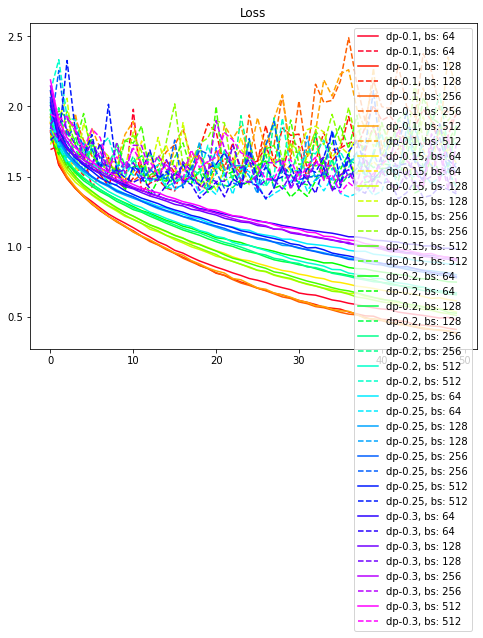

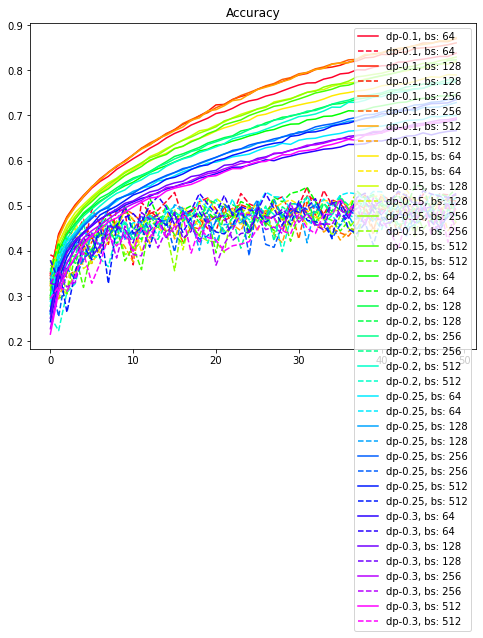

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
## regular_type L2
results = {}
for i, (drop_exp, batch_size) in enumerate(itertools.product(Dropout_EXP, BATCH_SIZE)):
    print("Numbers of exp: %i, drop_exp: %s, batch_size: %i, L2 ratio: %i" % (i, drop_exp, batch_size, EXP))
    model = build_mlp(input_shape=x_train.shape[1:], ratio=EXP, regular_type=l2, drop_ratio=drop_exp)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = "dp-%s, bs: %s" % (str(drop_exp),str(batch_size))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, drop_exp: 0.1, batch_size: 64, L2 ratio: 0
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_100 (Bat (None, 512)               2048      
_________________________________________________________________
activation_100 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________________________

Epoch 35/50
782/782 [==============================] - 9s 12ms/step - loss: 0.6238 - accuracy: 0.7848 - val_loss: 1.6178 - val_accuracy: 0.5279
Epoch 36/50
782/782 [==============================] - 9s 12ms/step - loss: 0.6015 - accuracy: 0.7939 - val_loss: 1.6838 - val_accuracy: 0.5143
Epoch 37/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5968 - accuracy: 0.7944 - val_loss: 1.6967 - val_accuracy: 0.5102
Epoch 38/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5894 - accuracy: 0.7974 - val_loss: 1.7104 - val_accuracy: 0.5124
Epoch 39/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5764 - accuracy: 0.8003 - val_loss: 1.7385 - val_accuracy: 0.4988
Epoch 40/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5583 - accuracy: 0.8080 - val_loss: 1.7095 - val_accuracy: 0.5142
Epoch 41/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5511 - accuracy: 0.8116 - val_loss: 1.7602 - val_accuracy:

Epoch 19/50
391/391 [==============================] - 5s 13ms/step - loss: 0.8611 - accuracy: 0.7015 - val_loss: 1.6173 - val_accuracy: 0.4781
Epoch 20/50
391/391 [==============================] - 5s 13ms/step - loss: 0.8332 - accuracy: 0.7096 - val_loss: 1.5726 - val_accuracy: 0.4891
Epoch 21/50
391/391 [==============================] - 5s 13ms/step - loss: 0.8067 - accuracy: 0.7210 - val_loss: 1.8321 - val_accuracy: 0.4606
Epoch 22/50
391/391 [==============================] - 5s 12ms/step - loss: 0.7832 - accuracy: 0.7307 - val_loss: 1.8579 - val_accuracy: 0.4375
Epoch 23/50
391/391 [==============================] - 5s 12ms/step - loss: 0.7613 - accuracy: 0.7377 - val_loss: 1.7532 - val_accuracy: 0.4590
Epoch 24/50
391/391 [==============================] - 5s 12ms/step - loss: 0.7424 - accuracy: 0.7424 - val_loss: 1.6486 - val_accuracy: 0.4752
Epoch 25/50
391/391 [==============================] - 5s 12ms/step - loss: 0.7212 - accuracy: 0.7521 - val_loss: 1.6513 - val_accuracy:

Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4843 - accuracy: 0.4745 - val_loss: 1.7169 - val_accuracy: 0.3880
Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4108 - accuracy: 0.5040 - val_loss: 1.8597 - val_accuracy: 0.3602
Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3524 - accuracy: 0.5239 - val_loss: 1.6339 - val_accuracy: 0.4109
Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2999 - accuracy: 0.5422 - val_loss: 1.5883 - val_accuracy: 0.4333
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2601 - accuracy: 0.5591 - val_loss: 1.4951 - val_accuracy: 0.4632
Epoch 8/50
196/196 [==============================] - 3s 16ms/step - loss: 1.2109 - accuracy: 0.5744 - val_loss: 1.7333 - val_accuracy: 0.4004
Epoch 9/50
196/196 [==============================] - 3s 16ms/step - loss: 1.1758 - accuracy: 0.5881 - val_loss: 1.6337 - val_accuracy: 0.4611

Epoch 1/50
98/98 [==============================] - 10s 107ms/step - loss: 1.9243 - accuracy: 0.3244 - val_loss: 1.8929 - val_accuracy: 0.3223
Epoch 2/50
98/98 [==============================] - 2s 21ms/step - loss: 1.6287 - accuracy: 0.4264 - val_loss: 1.7991 - val_accuracy: 0.3362
Epoch 3/50
98/98 [==============================] - 2s 21ms/step - loss: 1.5115 - accuracy: 0.4657 - val_loss: 1.6755 - val_accuracy: 0.4076
Epoch 4/50
98/98 [==============================] - 2s 21ms/step - loss: 1.4330 - accuracy: 0.4959 - val_loss: 1.8703 - val_accuracy: 0.3539
Epoch 5/50
98/98 [==============================] - 2s 21ms/step - loss: 1.3717 - accuracy: 0.5190 - val_loss: 1.5660 - val_accuracy: 0.4507
Epoch 6/50
98/98 [==============================] - 2s 21ms/step - loss: 1.3143 - accuracy: 0.5370 - val_loss: 1.5934 - val_accuracy: 0.4237
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 1.2710 - accuracy: 0.5544 - val_loss: 1.6330 - val_accuracy: 0.4262
Epoch 8/50


Epoch 1/50
782/782 [==============================] - 10s 12ms/step - loss: 1.8741 - accuracy: 0.3288 - val_loss: 1.7256 - val_accuracy: 0.3705
Epoch 2/50
782/782 [==============================] - 9s 12ms/step - loss: 1.6427 - accuracy: 0.4150 - val_loss: 1.5639 - val_accuracy: 0.4498
Epoch 3/50
782/782 [==============================] - 9s 12ms/step - loss: 1.5492 - accuracy: 0.4538 - val_loss: 1.5416 - val_accuracy: 0.4528
Epoch 4/50
782/782 [==============================] - 9s 12ms/step - loss: 1.4847 - accuracy: 0.4774 - val_loss: 1.5588 - val_accuracy: 0.4491
Epoch 5/50
782/782 [==============================] - 9s 12ms/step - loss: 1.4349 - accuracy: 0.4973 - val_loss: 1.8645 - val_accuracy: 0.3839
Epoch 6/50
782/782 [==============================] - 9s 12ms/step - loss: 1.3874 - accuracy: 0.5153 - val_loss: 1.8547 - val_accuracy: 0.3741
Epoch 7/50
782/782 [==============================] - 9s 12ms/step - loss: 1.3538 - accuracy: 0.5300 - val_loss: 1.5064 - val_accuracy: 0.461

Epoch 1/50
391/391 [==============================] - 5s 14ms/step - loss: 1.8842 - accuracy: 0.3224 - val_loss: 1.7799 - val_accuracy: 0.3596
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 1.6336 - accuracy: 0.4183 - val_loss: 1.7845 - val_accuracy: 0.3520
Epoch 3/50
391/391 [==============================] - 5s 13ms/step - loss: 1.5371 - accuracy: 0.4551 - val_loss: 1.6615 - val_accuracy: 0.3994
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 1.4719 - accuracy: 0.4789 - val_loss: 1.6795 - val_accuracy: 0.4082
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 1.4141 - accuracy: 0.5018 - val_loss: 1.5549 - val_accuracy: 0.4452
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 1.3693 - accuracy: 0.5183 - val_loss: 1.5299 - val_accuracy: 0.4438
Epoch 7/50
391/391 [==============================] - 5s 13ms/step - loss: 1.3283 - accuracy: 0.5363 - val_loss: 1.5385 - val_accuracy: 0.4508

Epoch 1/50
196/196 [==============================] - 3s 17ms/step - loss: 1.9415 - accuracy: 0.3025 - val_loss: 2.2003 - val_accuracy: 0.2359
Epoch 2/50
196/196 [==============================] - 3s 16ms/step - loss: 1.6570 - accuracy: 0.4115 - val_loss: 1.7876 - val_accuracy: 0.3465
Epoch 3/50
196/196 [==============================] - 3s 16ms/step - loss: 1.5503 - accuracy: 0.4516 - val_loss: 1.7159 - val_accuracy: 0.3817
Epoch 4/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4806 - accuracy: 0.4784 - val_loss: 1.6040 - val_accuracy: 0.4272
Epoch 5/50
196/196 [==============================] - 3s 16ms/step - loss: 1.4188 - accuracy: 0.5008 - val_loss: 1.7919 - val_accuracy: 0.3576
Epoch 6/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3711 - accuracy: 0.5175 - val_loss: 1.6153 - val_accuracy: 0.4152
Epoch 7/50
196/196 [==============================] - 3s 16ms/step - loss: 1.3242 - accuracy: 0.5362 - val_loss: 1.5442 - val_accuracy: 0.4506

Epoch 1/50
98/98 [==============================] - 2s 25ms/step - loss: 1.9933 - accuracy: 0.2962 - val_loss: 1.9016 - val_accuracy: 0.3111
Epoch 2/50
98/98 [==============================] - 4s 42ms/step - loss: 1.6818 - accuracy: 0.4040 - val_loss: 1.8810 - val_accuracy: 0.3199
Epoch 3/50
98/98 [==============================] - 2s 21ms/step - loss: 1.5694 - accuracy: 0.4444 - val_loss: 2.0075 - val_accuracy: 0.2998
Epoch 4/50
98/98 [==============================] - 2s 21ms/step - loss: 1.4955 - accuracy: 0.4732 - val_loss: 1.6907 - val_accuracy: 0.3849
Epoch 5/50
98/98 [==============================] - 2s 21ms/step - loss: 1.4410 - accuracy: 0.4938 - val_loss: 1.6297 - val_accuracy: 0.4110
Epoch 6/50
98/98 [==============================] - 2s 21ms/step - loss: 1.3932 - accuracy: 0.5120 - val_loss: 1.5460 - val_accuracy: 0.4506
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 1.3501 - accuracy: 0.5293 - val_loss: 1.5803 - val_accuracy: 0.4384
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 12s 15ms/step - loss: 1.9162 - accuracy: 0.3127 - val_loss: 1.8522 - val_accuracy: 0.3392
Epoch 2/50
782/782 [==============================] - 9s 11ms/step - loss: 1.6878 - accuracy: 0.4005 - val_loss: 1.8541 - val_accuracy: 0.3538
Epoch 3/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5925 - accuracy: 0.4399 - val_loss: 1.5711 - val_accuracy: 0.4425
Epoch 4/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5404 - accuracy: 0.4585 - val_loss: 1.5303 - val_accuracy: 0.4557
Epoch 5/50
782/782 [==============================] - 9s 12ms/step - loss: 1.4895 - accuracy: 0.4780 - val_loss: 1.5881 - val_accuracy: 0.4401
Epoch 6/50
782/782 [==============================] - 9s 11ms/step - loss: 1.4448 - accuracy: 0.4949 - val_loss: 1.5228 - val_accuracy: 0.4597
Epoch 7/50
782/782 [==============================] - 9s 11ms/step - loss: 1.4072 - accuracy: 0.5091 - val_loss: 2.0095 - val_accuracy: 0.333

Epoch 1/50
391/391 [==============================] - 5s 13ms/step - loss: 1.9470 - accuracy: 0.2981 - val_loss: 1.8934 - val_accuracy: 0.3094
Epoch 2/50
391/391 [==============================] - 5s 12ms/step - loss: 1.6896 - accuracy: 0.3969 - val_loss: 1.8805 - val_accuracy: 0.3483
Epoch 3/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5903 - accuracy: 0.4372 - val_loss: 1.6452 - val_accuracy: 0.4178
Epoch 4/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5245 - accuracy: 0.4637 - val_loss: 1.5947 - val_accuracy: 0.4347
Epoch 5/50
391/391 [==============================] - 5s 12ms/step - loss: 1.4723 - accuracy: 0.4850 - val_loss: 1.6725 - val_accuracy: 0.3998
Epoch 6/50
391/391 [==============================] - 5s 12ms/step - loss: 1.4279 - accuracy: 0.4992 - val_loss: 1.6149 - val_accuracy: 0.4134
Epoch 7/50
391/391 [==============================] - 5s 12ms/step - loss: 1.3853 - accuracy: 0.5159 - val_loss: 1.5858 - val_accuracy: 0.4283

Epoch 1/50
196/196 [==============================] - 3s 16ms/step - loss: 2.0065 - accuracy: 0.2822 - val_loss: 1.8321 - val_accuracy: 0.3420
Epoch 2/50
196/196 [==============================] - 3s 15ms/step - loss: 1.7235 - accuracy: 0.3850 - val_loss: 1.8023 - val_accuracy: 0.3572
Epoch 3/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6118 - accuracy: 0.4308 - val_loss: 1.8848 - val_accuracy: 0.3293
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5433 - accuracy: 0.4540 - val_loss: 1.7819 - val_accuracy: 0.3682
Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4938 - accuracy: 0.4756 - val_loss: 1.5975 - val_accuracy: 0.4380
Epoch 6/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4449 - accuracy: 0.4932 - val_loss: 1.6118 - val_accuracy: 0.4250
Epoch 7/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4018 - accuracy: 0.5099 - val_loss: 1.5791 - val_accuracy: 0.4479

Epoch 1/50
98/98 [==============================] - 2s 23ms/step - loss: 2.0394 - accuracy: 0.2694 - val_loss: 1.9608 - val_accuracy: 0.2972
Epoch 2/50
98/98 [==============================] - 2s 21ms/step - loss: 1.7559 - accuracy: 0.3709 - val_loss: 1.8423 - val_accuracy: 0.3299
Epoch 3/50
98/98 [==============================] - 2s 21ms/step - loss: 1.6458 - accuracy: 0.4144 - val_loss: 1.7627 - val_accuracy: 0.3706
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5608 - accuracy: 0.4468 - val_loss: 1.9783 - val_accuracy: 0.3144
Epoch 5/50
98/98 [==============================] - 2s 21ms/step - loss: 1.5065 - accuracy: 0.4693 - val_loss: 1.8231 - val_accuracy: 0.3492
Epoch 6/50
98/98 [==============================] - 2s 21ms/step - loss: 1.4612 - accuracy: 0.4833 - val_loss: 1.6341 - val_accuracy: 0.4116
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 1.4177 - accuracy: 0.5027 - val_loss: 1.6076 - val_accuracy: 0.4260
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 9s 12ms/step - loss: 1.9616 - accuracy: 0.2911 - val_loss: 1.8112 - val_accuracy: 0.3503
Epoch 2/50
782/782 [==============================] - 9s 12ms/step - loss: 1.7326 - accuracy: 0.3798 - val_loss: 1.6921 - val_accuracy: 0.3917
Epoch 3/50
782/782 [==============================] - 9s 11ms/step - loss: 1.6480 - accuracy: 0.4198 - val_loss: 1.5671 - val_accuracy: 0.4448
Epoch 4/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5881 - accuracy: 0.4405 - val_loss: 1.7486 - val_accuracy: 0.3675
Epoch 5/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5377 - accuracy: 0.4625 - val_loss: 1.9145 - val_accuracy: 0.3264
Epoch 6/50
782/782 [==============================] - 9s 11ms/step - loss: 1.4985 - accuracy: 0.4738 - val_loss: 1.5396 - val_accuracy: 0.4436
Epoch 7/50
782/782 [==============================] - 9s 11ms/step - loss: 1.4640 - accuracy: 0.4893 - val_loss: 1.5262 - val_accuracy: 0.4570

Epoch 1/50
391/391 [==============================] - 5s 13ms/step - loss: 2.0055 - accuracy: 0.2768 - val_loss: 1.7531 - val_accuracy: 0.3671
Epoch 2/50
391/391 [==============================] - 5s 12ms/step - loss: 1.7449 - accuracy: 0.3745 - val_loss: 1.8653 - val_accuracy: 0.3296
Epoch 3/50
391/391 [==============================] - 5s 12ms/step - loss: 1.6465 - accuracy: 0.4166 - val_loss: 1.6914 - val_accuracy: 0.3930
Epoch 4/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5787 - accuracy: 0.4454 - val_loss: 1.6654 - val_accuracy: 0.3952
Epoch 5/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5333 - accuracy: 0.4635 - val_loss: 1.6869 - val_accuracy: 0.3983
Epoch 6/50
391/391 [==============================] - 5s 12ms/step - loss: 1.4921 - accuracy: 0.4776 - val_loss: 1.6220 - val_accuracy: 0.4073
Epoch 7/50
391/391 [==============================] - 5s 12ms/step - loss: 1.4553 - accuracy: 0.4942 - val_loss: 1.5448 - val_accuracy: 0.4487

Epoch 1/50
196/196 [==============================] - 3s 16ms/step - loss: 2.0473 - accuracy: 0.2673 - val_loss: 1.8316 - val_accuracy: 0.3499
Epoch 2/50
196/196 [==============================] - 3s 15ms/step - loss: 1.7685 - accuracy: 0.3637 - val_loss: 2.0951 - val_accuracy: 0.2791
Epoch 3/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6644 - accuracy: 0.4083 - val_loss: 1.8755 - val_accuracy: 0.3221
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5958 - accuracy: 0.4343 - val_loss: 1.8869 - val_accuracy: 0.3219
Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5394 - accuracy: 0.4602 - val_loss: 1.6343 - val_accuracy: 0.4121
Epoch 6/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5023 - accuracy: 0.4727 - val_loss: 1.6205 - val_accuracy: 0.4128
Epoch 7/50
196/196 [==============================] - 3s 15ms/step - loss: 1.4633 - accuracy: 0.4880 - val_loss: 1.7135 - val_accuracy: 0.4120

Epoch 1/50
98/98 [==============================] - 2s 22ms/step - loss: 2.1307 - accuracy: 0.2336 - val_loss: 2.0181 - val_accuracy: 0.2513
Epoch 2/50
98/98 [==============================] - 2s 20ms/step - loss: 1.8275 - accuracy: 0.3406 - val_loss: 1.9122 - val_accuracy: 0.3144
Epoch 3/50
98/98 [==============================] - 2s 20ms/step - loss: 1.7211 - accuracy: 0.3844 - val_loss: 1.8647 - val_accuracy: 0.3097
Epoch 4/50
98/98 [==============================] - 2s 20ms/step - loss: 1.6432 - accuracy: 0.4158 - val_loss: 2.0201 - val_accuracy: 0.3012
Epoch 5/50
98/98 [==============================] - 2s 20ms/step - loss: 1.5809 - accuracy: 0.4426 - val_loss: 1.6242 - val_accuracy: 0.4206
Epoch 6/50
98/98 [==============================] - 2s 20ms/step - loss: 1.5341 - accuracy: 0.4622 - val_loss: 1.6024 - val_accuracy: 0.4247
Epoch 7/50
98/98 [==============================] - 2s 21ms/step - loss: 1.4953 - accuracy: 0.4745 - val_loss: 1.5863 - val_accuracy: 0.4243
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 9s 12ms/step - loss: 2.0273 - accuracy: 0.2660 - val_loss: 1.7885 - val_accuracy: 0.3495
Epoch 2/50
782/782 [==============================] - 9s 11ms/step - loss: 1.7810 - accuracy: 0.3617 - val_loss: 1.7036 - val_accuracy: 0.3788
Epoch 3/50
782/782 [==============================] - 9s 11ms/step - loss: 1.6978 - accuracy: 0.3979 - val_loss: 1.6550 - val_accuracy: 0.4053
Epoch 4/50
782/782 [==============================] - 9s 11ms/step - loss: 1.6331 - accuracy: 0.4275 - val_loss: 1.6087 - val_accuracy: 0.4259
Epoch 5/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5985 - accuracy: 0.4380 - val_loss: 1.5773 - val_accuracy: 0.4378
Epoch 6/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5559 - accuracy: 0.4573 - val_loss: 1.5697 - val_accuracy: 0.4363
Epoch 7/50
782/782 [==============================] - 9s 11ms/step - loss: 1.5246 - accuracy: 0.4679 - val_loss: 1.6766 - val_accuracy: 0.4036

Epoch 1/50
391/391 [==============================] - 5s 13ms/step - loss: 2.0528 - accuracy: 0.2524 - val_loss: 1.8114 - val_accuracy: 0.3458
Epoch 2/50
391/391 [==============================] - 5s 12ms/step - loss: 1.7986 - accuracy: 0.3476 - val_loss: 1.6757 - val_accuracy: 0.4013
Epoch 3/50
391/391 [==============================] - 5s 12ms/step - loss: 1.7024 - accuracy: 0.3909 - val_loss: 1.7344 - val_accuracy: 0.3709
Epoch 4/50
391/391 [==============================] - 5s 12ms/step - loss: 1.6433 - accuracy: 0.4199 - val_loss: 1.5599 - val_accuracy: 0.4458
Epoch 5/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5889 - accuracy: 0.4414 - val_loss: 1.6051 - val_accuracy: 0.4309
Epoch 6/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5549 - accuracy: 0.4547 - val_loss: 1.6928 - val_accuracy: 0.3987
Epoch 7/50
391/391 [==============================] - 5s 12ms/step - loss: 1.5148 - accuracy: 0.4744 - val_loss: 1.6397 - val_accuracy: 0.4185

Epoch 1/50
196/196 [==============================] - 3s 17ms/step - loss: 2.1286 - accuracy: 0.2310 - val_loss: 1.8838 - val_accuracy: 0.3166
Epoch 2/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8463 - accuracy: 0.3292 - val_loss: 1.8547 - val_accuracy: 0.3365
Epoch 3/50
196/196 [==============================] - 3s 15ms/step - loss: 1.7387 - accuracy: 0.3782 - val_loss: 1.9853 - val_accuracy: 0.3032
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6659 - accuracy: 0.4085 - val_loss: 1.5744 - val_accuracy: 0.4427
Epoch 5/50
196/196 [==============================] - 3s 15ms/step - loss: 1.6153 - accuracy: 0.4305 - val_loss: 1.7555 - val_accuracy: 0.3803
Epoch 6/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5732 - accuracy: 0.4456 - val_loss: 1.5928 - val_accuracy: 0.4281
Epoch 7/50
196/196 [==============================] - 3s 15ms/step - loss: 1.5310 - accuracy: 0.4621 - val_loss: 1.5799 - val_accuracy: 0.4285

Epoch 1/50
98/98 [==============================] - 5s 56ms/step - loss: 2.2239 - accuracy: 0.2122 - val_loss: 2.0603 - val_accuracy: 0.2412
Epoch 2/50
98/98 [==============================] - 8s 80ms/step - loss: 1.9095 - accuracy: 0.3127 - val_loss: 1.7952 - val_accuracy: 0.3565
Epoch 3/50
98/98 [==============================] - 2s 22ms/step - loss: 1.7850 - accuracy: 0.3621 - val_loss: 1.8848 - val_accuracy: 0.3267
Epoch 4/50
98/98 [==============================] - 7s 67ms/step - loss: 1.7062 - accuracy: 0.3926 - val_loss: 1.8607 - val_accuracy: 0.3295
Epoch 5/50
98/98 [==============================] - 2s 20ms/step - loss: 1.6468 - accuracy: 0.4162 - val_loss: 1.7825 - val_accuracy: 0.3695
Epoch 6/50
98/98 [==============================] - 2s 20ms/step - loss: 1.5996 - accuracy: 0.4375 - val_loss: 1.6996 - val_accuracy: 0.3832
Epoch 7/50
98/98 [==============================] - 2s 20ms/step - loss: 1.5657 - accuracy: 0.4531 - val_loss: 1.5610 - val_accuracy: 0.4435
Epoch 8/50
98

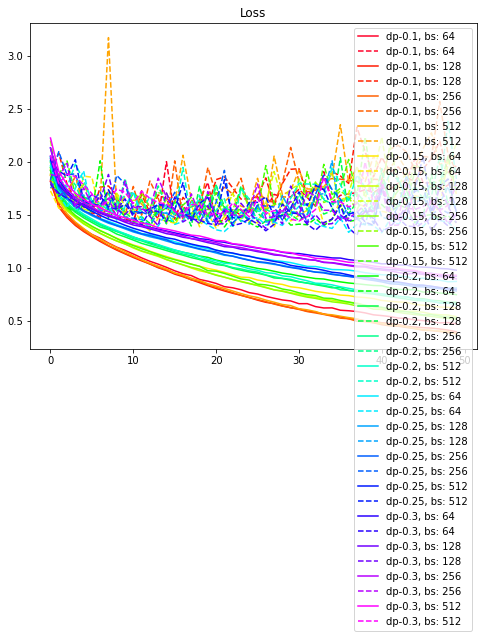

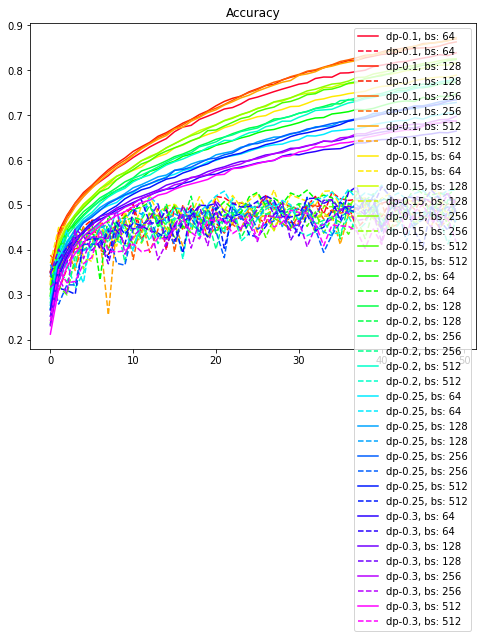

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
from keras.layers import BatchNormalization, Activation
def build_mlp_mix(input_shape, regular_type, output_units=10, num_neurons=[512, 256, 128, 64, 32], ratio=1e-12, drop_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regular_type(ratio,ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regular_type(ratio,ratio))(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drop_ratio)(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
## regular_type L1+L2 Mix
results = {}
for i, (drop_exp, batch_size) in enumerate(itertools.product(Dropout_EXP, BATCH_SIZE)):
    print("Numbers of exp: %i, drop_exp: %s, batch_size: %i, L1 ratio: %i, L2 ratio: %i" % (i, drop_exp, batch_size, EXP, EXP))
    model = build_mlp_mix(input_shape=x_train.shape[1:], ratio=EXP, regular_type=l1_l2, drop_ratio=drop_exp)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = "dp-%s, bs: %s" % (str(drop_exp),str(batch_size))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, drop_exp: 0.1, batch_size: 64, L1 ratio: 0, L2 ratio: 0
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_200 (Bat (None, 512)               2048      
_________________________________________________________________
activation_200 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_200 (Dropout)        (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 18/50
391/391 [==============================] - 6s 15ms/step - loss: 0.8875 - accuracy: 0.6927 - val_loss: 1.6624 - val_accuracy: 0.4514
Epoch 19/50
391/391 [==============================] - 6s 15ms/step - loss: 0.8679 - accuracy: 0.6992 - val_loss: 2.0345 - val_accuracy: 0.3885
Epoch 20/50
391/391 [==============================] - 6s 15ms/step - loss: 0.8368 - accuracy: 0.7088 - val_loss: 1.9252 - val_accuracy: 0.4148
Epoch 21/50
391/391 [==============================] - 6s 15ms/step - loss: 0.8145 - accuracy: 0.7162 - val_loss: 1.6111 - val_accuracy: 0.4652
Epoch 22/50
391/391 [==============================] - 6s 15ms/step - loss: 0.7897 - accuracy: 0.7252 - val_loss: 1.5551 - val_accuracy: 0.4960
Epoch 23/50
391/391 [==============================] - 6s 15ms/step - loss: 0.7673 - accuracy: 0.7355 - val_loss: 1.8886 - val_accuracy: 0.4424
Epoch 24/50
391/391 [==============================] - 6s 15ms/step - loss: 0.7477 - accuracy: 0.7414 - val_loss: 1.6339 - val_accuracy:

Epoch 1/50
98/98 [==============================] - 3s 27ms/step - loss: 1.9336 - accuracy: 0.3182 - val_loss: 1.9175 - val_accuracy: 0.3118
Epoch 2/50
98/98 [==============================] - 2s 24ms/step - loss: 1.6349 - accuracy: 0.4200 - val_loss: 1.8431 - val_accuracy: 0.3433
Epoch 3/50
98/98 [==============================] - 2s 24ms/step - loss: 1.5194 - accuracy: 0.4616 - val_loss: 1.7010 - val_accuracy: 0.3893
Epoch 4/50
98/98 [==============================] - 2s 24ms/step - loss: 1.4387 - accuracy: 0.4930 - val_loss: 1.8921 - val_accuracy: 0.3255
Epoch 5/50
98/98 [==============================] - 2s 24ms/step - loss: 1.3728 - accuracy: 0.5151 - val_loss: 1.7362 - val_accuracy: 0.3853
Epoch 6/50
98/98 [==============================] - 2s 24ms/step - loss: 1.3174 - accuracy: 0.5364 - val_loss: 1.6691 - val_accuracy: 0.4157
Epoch 7/50
98/98 [==============================] - 2s 25ms/step - loss: 1.2705 - accuracy: 0.5555 - val_loss: 1.6137 - val_accuracy: 0.4257
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 12s 15ms/step - loss: 1.8690 - accuracy: 0.3302 - val_loss: 1.8214 - val_accuracy: 0.3505
Epoch 2/50
782/782 [==============================] - 11s 14ms/step - loss: 1.6332 - accuracy: 0.4201 - val_loss: 1.7240 - val_accuracy: 0.3884
Epoch 3/50
782/782 [==============================] - 11s 14ms/step - loss: 1.5416 - accuracy: 0.4564 - val_loss: 1.5578 - val_accuracy: 0.4470
Epoch 4/50
782/782 [==============================] - 11s 15ms/step - loss: 1.4762 - accuracy: 0.4778 - val_loss: 1.5830 - val_accuracy: 0.4249
Epoch 5/50
782/782 [==============================] - 12s 15ms/step - loss: 1.4209 - accuracy: 0.5005 - val_loss: 1.6269 - val_accuracy: 0.4367
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 1.3795 - accuracy: 0.5162 - val_loss: 1.4700 - val_accuracy: 0.4630
Epoch 7/50
782/782 [==============================] - 11s 15ms/step - loss: 1.3373 - accuracy: 0.5304 - val_loss: 1.4225 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 6s 16ms/step - loss: 1.8829 - accuracy: 0.3221 - val_loss: 1.7635 - val_accuracy: 0.3602
Epoch 2/50
391/391 [==============================] - 6s 15ms/step - loss: 1.6396 - accuracy: 0.4186 - val_loss: 1.9012 - val_accuracy: 0.3380
Epoch 3/50
391/391 [==============================] - 6s 15ms/step - loss: 1.5391 - accuracy: 0.4566 - val_loss: 1.6217 - val_accuracy: 0.4193
Epoch 4/50
391/391 [==============================] - 6s 15ms/step - loss: 1.4663 - accuracy: 0.4818 - val_loss: 1.5689 - val_accuracy: 0.4350
Epoch 5/50
391/391 [==============================] - 6s 15ms/step - loss: 1.4131 - accuracy: 0.5046 - val_loss: 1.5590 - val_accuracy: 0.4340
Epoch 6/50
391/391 [==============================] - 6s 15ms/step - loss: 1.3634 - accuracy: 0.5238 - val_loss: 1.5533 - val_accuracy: 0.4498
Epoch 7/50
391/391 [==============================] - 6s 15ms/step - loss: 1.3274 - accuracy: 0.5376 - val_loss: 1.5243 - val_accuracy: 0.4529

Epoch 1/50
196/196 [==============================] - 4s 19ms/step - loss: 1.9158 - accuracy: 0.3156 - val_loss: 1.9371 - val_accuracy: 0.3160
Epoch 2/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6480 - accuracy: 0.4129 - val_loss: 1.8690 - val_accuracy: 0.3414
Epoch 3/50
196/196 [==============================] - 3s 17ms/step - loss: 1.5469 - accuracy: 0.4513 - val_loss: 1.8029 - val_accuracy: 0.3668
Epoch 4/50
196/196 [==============================] - 3s 17ms/step - loss: 1.4739 - accuracy: 0.4810 - val_loss: 1.6824 - val_accuracy: 0.3915
Epoch 5/50
196/196 [==============================] - 3s 17ms/step - loss: 1.4180 - accuracy: 0.5019 - val_loss: 1.5925 - val_accuracy: 0.4392
Epoch 6/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3709 - accuracy: 0.5154 - val_loss: 1.6295 - val_accuracy: 0.4103
Epoch 7/50
196/196 [==============================] - 3s 17ms/step - loss: 1.3335 - accuracy: 0.5317 - val_loss: 1.5672 - val_accuracy: 0.4424

Epoch 1/50
98/98 [==============================] - 3s 26ms/step - loss: 1.9845 - accuracy: 0.2895 - val_loss: 1.8882 - val_accuracy: 0.3235
Epoch 2/50
98/98 [==============================] - 2s 23ms/step - loss: 1.6943 - accuracy: 0.3998 - val_loss: 2.0031 - val_accuracy: 0.2517
Epoch 3/50
98/98 [==============================] - 2s 23ms/step - loss: 1.5828 - accuracy: 0.4379 - val_loss: 1.7598 - val_accuracy: 0.3779
Epoch 4/50
98/98 [==============================] - 2s 23ms/step - loss: 1.4985 - accuracy: 0.4702 - val_loss: 1.7727 - val_accuracy: 0.3657
Epoch 5/50
98/98 [==============================] - 2s 24ms/step - loss: 1.4445 - accuracy: 0.4912 - val_loss: 1.7896 - val_accuracy: 0.3585
Epoch 6/50
98/98 [==============================] - 3s 28ms/step - loss: 1.3932 - accuracy: 0.5113 - val_loss: 1.6267 - val_accuracy: 0.4152
Epoch 7/50
98/98 [==============================] - 2s 23ms/step - loss: 1.3508 - accuracy: 0.5261 - val_loss: 1.4895 - val_accuracy: 0.4760
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 11s 14ms/step - loss: 1.9081 - accuracy: 0.3118 - val_loss: 1.8754 - val_accuracy: 0.3104
Epoch 2/50
782/782 [==============================] - 11s 14ms/step - loss: 1.6873 - accuracy: 0.3987 - val_loss: 1.6204 - val_accuracy: 0.4247
Epoch 3/50
782/782 [==============================] - 11s 14ms/step - loss: 1.6025 - accuracy: 0.4376 - val_loss: 1.8658 - val_accuracy: 0.3500
Epoch 4/50
782/782 [==============================] - 11s 14ms/step - loss: 1.5331 - accuracy: 0.4609 - val_loss: 1.6048 - val_accuracy: 0.4254
Epoch 5/50
782/782 [==============================] - 11s 14ms/step - loss: 1.4874 - accuracy: 0.4784 - val_loss: 1.6786 - val_accuracy: 0.4135
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 1.4421 - accuracy: 0.4967 - val_loss: 1.5008 - val_accuracy: 0.4724
Epoch 7/50
782/782 [==============================] - 11s 14ms/step - loss: 1.4070 - accuracy: 0.5099 - val_loss: 1.5438 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 6s 16ms/step - loss: 1.9491 - accuracy: 0.2987 - val_loss: 1.7384 - val_accuracy: 0.3823
Epoch 2/50
391/391 [==============================] - 6s 15ms/step - loss: 1.6936 - accuracy: 0.3979 - val_loss: 1.7333 - val_accuracy: 0.3792
Epoch 3/50
391/391 [==============================] - 6s 15ms/step - loss: 1.5891 - accuracy: 0.4366 - val_loss: 1.7309 - val_accuracy: 0.3793
Epoch 4/50
391/391 [==============================] - 6s 16ms/step - loss: 1.5192 - accuracy: 0.4633 - val_loss: 1.8749 - val_accuracy: 0.3620
Epoch 5/50
391/391 [==============================] - 6s 15ms/step - loss: 1.4733 - accuracy: 0.4834 - val_loss: 1.6252 - val_accuracy: 0.4238
Epoch 6/50
391/391 [==============================] - 6s 15ms/step - loss: 1.4279 - accuracy: 0.5007 - val_loss: 1.5790 - val_accuracy: 0.4439
Epoch 7/50
391/391 [==============================] - 6s 15ms/step - loss: 1.3893 - accuracy: 0.5125 - val_loss: 1.7349 - val_accuracy: 0.3963

Epoch 1/50
196/196 [==============================] - 4s 19ms/step - loss: 2.0024 - accuracy: 0.2830 - val_loss: 1.8376 - val_accuracy: 0.3420
Epoch 2/50
196/196 [==============================] - 3s 17ms/step - loss: 1.7199 - accuracy: 0.3860 - val_loss: 1.7404 - val_accuracy: 0.3788
Epoch 3/50
196/196 [==============================] - 3s 18ms/step - loss: 1.6078 - accuracy: 0.4298 - val_loss: 1.7294 - val_accuracy: 0.3662
Epoch 4/50
196/196 [==============================] - 3s 18ms/step - loss: 1.5343 - accuracy: 0.4591 - val_loss: 1.8232 - val_accuracy: 0.3612
Epoch 5/50
196/196 [==============================] - 3s 18ms/step - loss: 1.4815 - accuracy: 0.4820 - val_loss: 1.8750 - val_accuracy: 0.3258
Epoch 6/50
196/196 [==============================] - 4s 18ms/step - loss: 1.4379 - accuracy: 0.4974 - val_loss: 1.9951 - val_accuracy: 0.3127
Epoch 7/50
196/196 [==============================] - 3s 18ms/step - loss: 1.4036 - accuracy: 0.5119 - val_loss: 1.5417 - val_accuracy: 0.4474

Epoch 1/50
98/98 [==============================] - 12s 123ms/step - loss: 2.0805 - accuracy: 0.2600 - val_loss: 1.9812 - val_accuracy: 0.2918
Epoch 2/50
98/98 [==============================] - 2s 25ms/step - loss: 1.7701 - accuracy: 0.3716 - val_loss: 1.9215 - val_accuracy: 0.3105
Epoch 3/50
98/98 [==============================] - 7s 75ms/step - loss: 1.6511 - accuracy: 0.4124 - val_loss: 1.7586 - val_accuracy: 0.3696
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5816 - accuracy: 0.4421 - val_loss: 1.8627 - val_accuracy: 0.3428
Epoch 5/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5160 - accuracy: 0.4672 - val_loss: 1.7109 - val_accuracy: 0.3875
Epoch 6/50
98/98 [==============================] - 2s 22ms/step - loss: 1.4685 - accuracy: 0.4870 - val_loss: 1.5669 - val_accuracy: 0.4419
Epoch 7/50
98/98 [==============================] - 2s 22ms/step - loss: 1.4319 - accuracy: 0.4989 - val_loss: 1.5968 - val_accuracy: 0.4290
Epoch 8/50


Epoch 1/50
782/782 [==============================] - 11s 14ms/step - loss: 1.9730 - accuracy: 0.2860 - val_loss: 1.8002 - val_accuracy: 0.3417
Epoch 2/50
782/782 [==============================] - 11s 14ms/step - loss: 1.7400 - accuracy: 0.3794 - val_loss: 1.7297 - val_accuracy: 0.3750
Epoch 3/50
782/782 [==============================] - 11s 14ms/step - loss: 1.6404 - accuracy: 0.4210 - val_loss: 1.7816 - val_accuracy: 0.3432
Epoch 4/50
782/782 [==============================] - 11s 14ms/step - loss: 1.5874 - accuracy: 0.4402 - val_loss: 1.7671 - val_accuracy: 0.3833
Epoch 5/50
782/782 [==============================] - 11s 14ms/step - loss: 1.5413 - accuracy: 0.4608 - val_loss: 1.5855 - val_accuracy: 0.4403
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 1.4957 - accuracy: 0.4767 - val_loss: 1.5514 - val_accuracy: 0.4554
Epoch 7/50
782/782 [==============================] - 11s 14ms/step - loss: 1.4632 - accuracy: 0.4897 - val_loss: 1.4926 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 13s 34ms/step - loss: 2.0176 - accuracy: 0.2765 - val_loss: 1.7452 - val_accuracy: 0.3672
Epoch 2/50
391/391 [==============================] - 6s 15ms/step - loss: 1.7474 - accuracy: 0.3721 - val_loss: 1.7724 - val_accuracy: 0.3525
Epoch 3/50
391/391 [==============================] - 6s 15ms/step - loss: 1.6456 - accuracy: 0.4159 - val_loss: 1.8100 - val_accuracy: 0.3499
Epoch 4/50
391/391 [==============================] - 6s 15ms/step - loss: 1.5828 - accuracy: 0.4409 - val_loss: 1.6319 - val_accuracy: 0.4083
Epoch 5/50
391/391 [==============================] - 6s 15ms/step - loss: 1.5346 - accuracy: 0.4618 - val_loss: 1.8840 - val_accuracy: 0.3346
Epoch 6/50
391/391 [==============================] - 6s 15ms/step - loss: 1.4923 - accuracy: 0.4798 - val_loss: 1.8442 - val_accuracy: 0.3773
Epoch 7/50
391/391 [==============================] - 6s 15ms/step - loss: 1.4553 - accuracy: 0.4898 - val_loss: 1.6169 - val_accuracy: 0.424

Epoch 1/50
196/196 [==============================] - 7s 33ms/step - loss: 2.0480 - accuracy: 0.2635 - val_loss: 1.7735 - val_accuracy: 0.3573
Epoch 2/50
196/196 [==============================] - 3s 18ms/step - loss: 1.7829 - accuracy: 0.3577 - val_loss: 1.8968 - val_accuracy: 0.3078
Epoch 3/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6707 - accuracy: 0.4066 - val_loss: 1.9045 - val_accuracy: 0.3221
Epoch 4/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6027 - accuracy: 0.4325 - val_loss: 1.6611 - val_accuracy: 0.3944
Epoch 5/50
196/196 [==============================] - 3s 17ms/step - loss: 1.5486 - accuracy: 0.4588 - val_loss: 1.7817 - val_accuracy: 0.3696
Epoch 6/50
196/196 [==============================] - 3s 18ms/step - loss: 1.5061 - accuracy: 0.4739 - val_loss: 1.5309 - val_accuracy: 0.4559
Epoch 7/50
196/196 [==============================] - 3s 17ms/step - loss: 1.4697 - accuracy: 0.4848 - val_loss: 1.8386 - val_accuracy: 0.3818

Epoch 1/50
98/98 [==============================] - 3s 31ms/step - loss: 2.1423 - accuracy: 0.2354 - val_loss: 1.9691 - val_accuracy: 0.2959
Epoch 2/50
98/98 [==============================] - 2s 22ms/step - loss: 1.8501 - accuracy: 0.3367 - val_loss: 1.8885 - val_accuracy: 0.3045
Epoch 3/50
98/98 [==============================] - 2s 22ms/step - loss: 1.7277 - accuracy: 0.3835 - val_loss: 2.2144 - val_accuracy: 0.2642
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 1.6495 - accuracy: 0.4122 - val_loss: 1.6943 - val_accuracy: 0.3843
Epoch 5/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5911 - accuracy: 0.4381 - val_loss: 2.0600 - val_accuracy: 0.3237
Epoch 6/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5440 - accuracy: 0.4595 - val_loss: 1.6278 - val_accuracy: 0.4110
Epoch 7/50
98/98 [==============================] - 2s 22ms/step - loss: 1.5035 - accuracy: 0.4748 - val_loss: 1.8779 - val_accuracy: 0.3294
Epoch 8/50
98

Epoch 1/50
782/782 [==============================] - 11s 14ms/step - loss: 2.0061 - accuracy: 0.2726 - val_loss: 1.8799 - val_accuracy: 0.3231
Epoch 2/50
782/782 [==============================] - 11s 14ms/step - loss: 1.7746 - accuracy: 0.3631 - val_loss: 1.7051 - val_accuracy: 0.3933
Epoch 3/50
782/782 [==============================] - 11s 14ms/step - loss: 1.6878 - accuracy: 0.4021 - val_loss: 1.8674 - val_accuracy: 0.3393
Epoch 4/50
782/782 [==============================] - 11s 14ms/step - loss: 1.6343 - accuracy: 0.4250 - val_loss: 1.6446 - val_accuracy: 0.4141
Epoch 5/50
782/782 [==============================] - 11s 14ms/step - loss: 1.5944 - accuracy: 0.4427 - val_loss: 1.6621 - val_accuracy: 0.4151
Epoch 6/50
782/782 [==============================] - 11s 14ms/step - loss: 1.5581 - accuracy: 0.4573 - val_loss: 1.7810 - val_accuracy: 0.3781
Epoch 7/50
782/782 [==============================] - 11s 14ms/step - loss: 1.5283 - accuracy: 0.4647 - val_loss: 1.7709 - val_accuracy:

Epoch 1/50
391/391 [==============================] - 6s 16ms/step - loss: 2.0842 - accuracy: 0.2482 - val_loss: 1.8213 - val_accuracy: 0.3377
Epoch 2/50
391/391 [==============================] - 6s 15ms/step - loss: 1.8038 - accuracy: 0.3488 - val_loss: 1.7357 - val_accuracy: 0.3613
Epoch 3/50
391/391 [==============================] - 6s 15ms/step - loss: 1.7093 - accuracy: 0.3933 - val_loss: 1.7739 - val_accuracy: 0.3552
Epoch 4/50
391/391 [==============================] - 6s 15ms/step - loss: 1.6421 - accuracy: 0.4194 - val_loss: 1.8828 - val_accuracy: 0.3367
Epoch 5/50
391/391 [==============================] - 6s 15ms/step - loss: 1.5980 - accuracy: 0.4400 - val_loss: 1.8330 - val_accuracy: 0.3523
Epoch 6/50
391/391 [==============================] - 6s 15ms/step - loss: 1.5566 - accuracy: 0.4527 - val_loss: 1.6015 - val_accuracy: 0.4242
Epoch 7/50
391/391 [==============================] - 6s 15ms/step - loss: 1.5154 - accuracy: 0.4727 - val_loss: 1.5237 - val_accuracy: 0.4479

Epoch 1/50
196/196 [==============================] - 4s 21ms/step - loss: 2.1676 - accuracy: 0.2199 - val_loss: 1.8737 - val_accuracy: 0.3268
Epoch 2/50
196/196 [==============================] - 3s 18ms/step - loss: 1.8641 - accuracy: 0.3271 - val_loss: 2.0399 - val_accuracy: 0.2872
Epoch 3/50
196/196 [==============================] - 3s 18ms/step - loss: 1.7363 - accuracy: 0.3798 - val_loss: 1.6739 - val_accuracy: 0.4033
Epoch 4/50
196/196 [==============================] - 3s 17ms/step - loss: 1.6643 - accuracy: 0.4091 - val_loss: 1.7176 - val_accuracy: 0.3980
Epoch 5/50
196/196 [==============================] - 3s 18ms/step - loss: 1.6042 - accuracy: 0.4363 - val_loss: 1.6551 - val_accuracy: 0.3966
Epoch 6/50
196/196 [==============================] - 3s 18ms/step - loss: 1.5744 - accuracy: 0.4466 - val_loss: 1.6444 - val_accuracy: 0.4064
Epoch 7/50
196/196 [==============================] - 3s 18ms/step - loss: 1.5312 - accuracy: 0.4666 - val_loss: 1.5920 - val_accuracy: 0.4332

Epoch 1/50
98/98 [==============================] - 2s 25ms/step - loss: 2.2263 - accuracy: 0.2140 - val_loss: 2.2212 - val_accuracy: 0.2224
Epoch 2/50
98/98 [==============================] - 2s 23ms/step - loss: 1.9251 - accuracy: 0.3046 - val_loss: 1.7858 - val_accuracy: 0.3647
Epoch 3/50
98/98 [==============================] - 2s 22ms/step - loss: 1.7990 - accuracy: 0.3552 - val_loss: 1.8155 - val_accuracy: 0.3446
Epoch 4/50
98/98 [==============================] - 2s 22ms/step - loss: 1.7220 - accuracy: 0.3863 - val_loss: 1.7187 - val_accuracy: 0.3898
Epoch 5/50
98/98 [==============================] - 2s 23ms/step - loss: 1.6622 - accuracy: 0.4108 - val_loss: 1.7587 - val_accuracy: 0.3628
Epoch 6/50
98/98 [==============================] - 2s 23ms/step - loss: 1.6152 - accuracy: 0.4305 - val_loss: 1.6674 - val_accuracy: 0.4004
Epoch 7/50
98/98 [==============================] - 2s 24ms/step - loss: 1.5756 - accuracy: 0.4469 - val_loss: 1.8388 - val_accuracy: 0.3422
Epoch 8/50
98

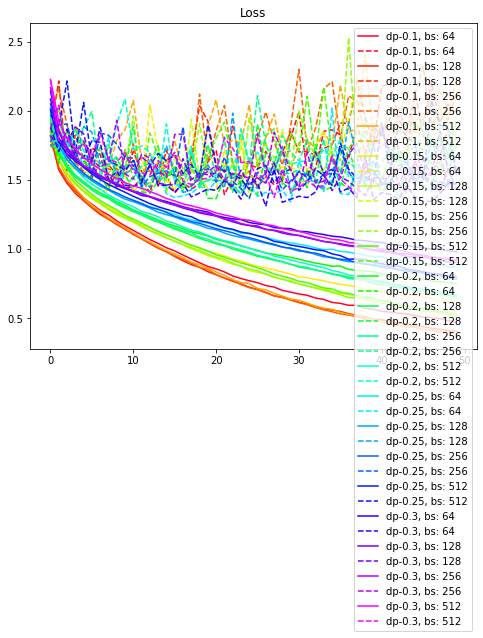

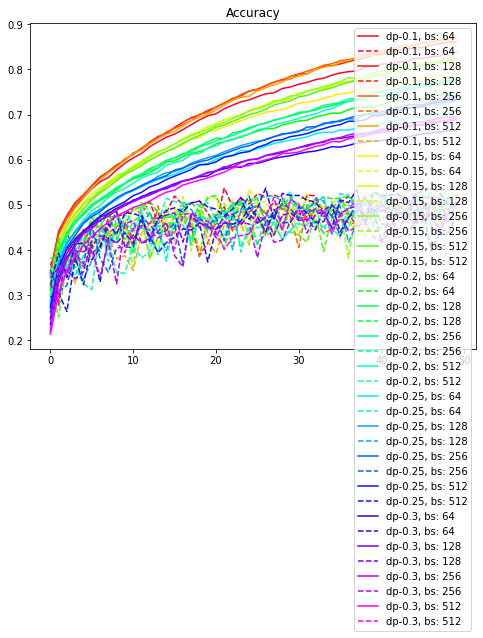

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [2]:
'''
以此例子來看，三種regularization比較(L1、L2以及L1_L2)。
L1: 
以訓練集來說，當 drop_ratio = 0.1、batch_size = 512時，準確率可達0.8723。
以測試集來說，當 drop_ratio = 0.2、batch_size = 64時，準確率可達0.5380。
L2: 
以訓練集來說，當 drop_ratio = 0.1、batch_size = 512時，準確率可達0.8729。
以測試集來說，當 drop_ratio = 0.2、batch_size = 64時，準確率可達0.5377。
L1_L2: 
以訓練集來說，當 drop_ratio = 0.1、batch_size = 256時，準確率可達0.8702。
以測試集來說，當 drop_ratio = 0.15、batch_size = 128時，準確率可達0.5146。
-
以上述參數得知，在drop_ratio = 0.1~0.2左右且batch_size = 512 or 64時，此訓練結果會較佳。而單純使用L1或單純使用L2的效果較兩者綜合的結果好。
'''

'\n以此例子來看，三種regularization比較(L1、L2以及L1_L2)，準確率最高的是L2。\nL1: \n以訓練集來說，當 drop_ratio = 0.1、batch_size = 512時，準確率可達0.8723。\n以測試集來說，當 drop_ratio = 0.2、batch_size = 64時，準確率可達0.5380。\nL2: \n以訓練集來說，當 drop_ratio = 0.1、batch_size = 512時，準確率可達0.8729。\n以測試集來說，當 drop_ratio = 0.2、batch_size = 64時，準確率可達0.5377。\nL1_L2: \n以訓練集來說，當 drop_ratio = 0.1、batch_size = 256時，準確率可達0.8702。\n以測試集來說，當 drop_ratio = 0.15、batch_size = 128時，準確率可達0.5146。\n以上述參數得知，在drop_ratio = 0.1~0.2左右且batch_size = 512 or 64時，此訓練結果會較佳。\n'